In [2]:
# imports
import pandas as pd
from sklearn.decomposition import PCA, SparsePCA, IncrementalPCA
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import torch
import torch.nn as nn
from biom import load_table
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from TRPCA import trpca
from tqdm.notebook import tqdm 
from gemelli.preprocessing import matrix_rclr

In [ ]:
import importlib
importlib.reload(trpca)

In [ ]:
table = pd.read_csv('data/control.csv', index_col=0)
age_metadata = pd.read_csv('data/sampleMetadata.csv', index_col='sample_id', dtype={'age': float})
shared_index = table.index.intersection(age_metadata.loc[(age_metadata.age.notna())&(age_metadata.body_site=='skin')].index)
table = table.loc[shared_index].drop(columns=['study_name','study_condition','subject_id'])
age_metadata = age_metadata.loc[shared_index]

table = (table*1e7).round().astype(int)
df1 = pd.DataFrame(matrix_rclr(table.values), index=table.index, columns=table.columns).fillna(0)#

all_zero_columns = (df1 == 0).all(axis=0)
num_all_zero_columns = all_zero_columns.sum()

print(f'Number of columns with all zeros: {num_all_zero_columns}')
df1 = df1.loc[:, ~all_zero_columns]

# Data preparation
y_np = age_metadata.age.astype(float)
X_np = table.to_numpy()
subjects = age_metadata.subject_id  # Assuming 'Subject' column is in age_metadata

Number of columns with all zeros: 1473


/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/2693533492.py:3: DtypeWarning: Columns (21,22,25,28,29,30,32,33,35,38,51,52,53,54,55,56,57,58,63,64,65,67,68,69,74,75,76,80,90,91,92,93,96,104,105,108,109,111,112,116,117,118,119,120,121,126,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  age_metadata = pd.read_csv('data/sampleMetadata.csv', index_col='sample_id', dtype={'age': float})


### Save these as designated files for simplicity...

In [ ]:
from TRPCA import utils
df1 = df1.loc[age_metadata.index]

In [9]:
n_dimensions = 32
# # # # # # Preprocess with PCA (Re-using the PCA application code from earlier)
X1_reduced, pca1 = utils.apply_pca(df1, n_dimensions) 
df = pd.DataFrame(X1_reduced, index=df1.index)

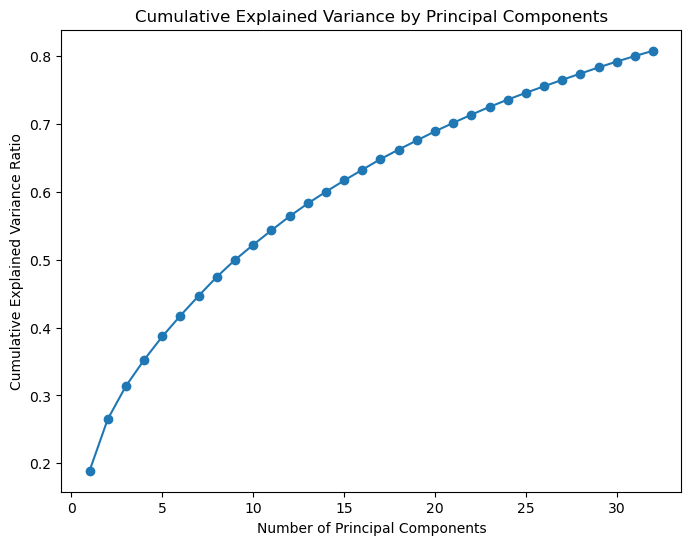

In [10]:
import numpy as np
import matplotlib.pyplot as plt

cum_explained_variance_ratio = np.cumsum(pca1.explained_variance_ratio_)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cum_explained_variance_ratio) + 1), cum_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by Principal Components')
plt.show()

In [11]:
df['age'] = age_metadata.loc[age_metadata.index.isin(df.index)].age
df = df.loc[df.age.notna()]

In [12]:
age_metadata = age_metadata.loc[df.index]

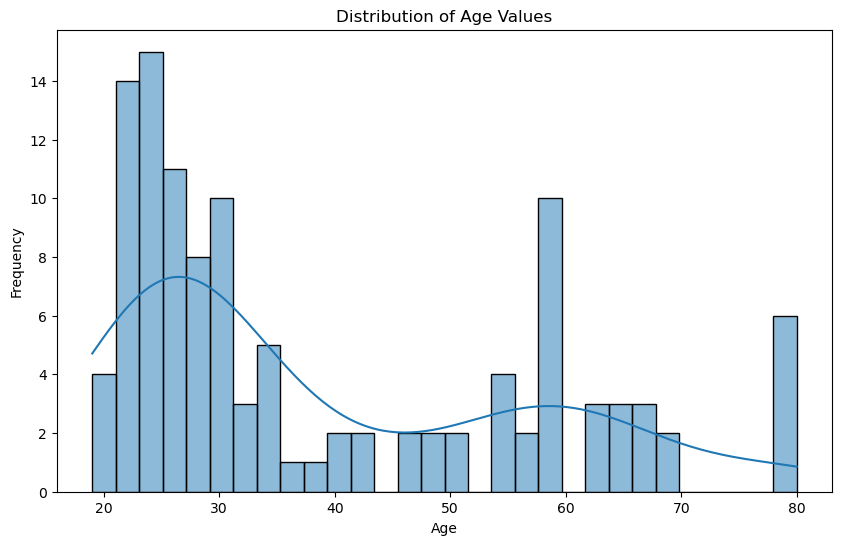

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of age values using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Age Values')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from TRPCA import trpca

y = df.age.astype(float)

X_pca_tensor = torch.tensor(df.drop(columns=['age']).to_numpy(), dtype=torch.float32)
# Get bin edges and create labels based on actual ranges
bins = pd.qcut(age_metadata['age'], q=5, retbins=True)
labels = [f'{int(bins[1][i])}-{int(bins[1][i+1])}' for i in range(len(bins[1])-1)]
age_metadata['age_group'] = pd.qcut(age_metadata['age'], q=5, labels=labels)

# Splitting the dataset
groups = age_metadata['subject_id']  # Subject
X_train, X_test, y_train, y_test = train_test_split(X_pca_tensor, y, test_size=0.2, random_state=42, stratify=age_metadata.study_name.astype(str))

# Standardizing the data
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train = X_train.numpy()
X_test = X_test.numpy()

# Converting to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
train_targets = torch.tensor(y_train.iloc[:].values, dtype=torch.float32).unsqueeze(1)
test_targets = torch.tensor(y_test.iloc[:].values, dtype=torch.float32).unsqueeze(1)

# Creating DataLoader instances
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

regression_model = trpca.TransformerRegressionModel(feature_size=n_dimensions, num_transformer_layers=1, nhead=8, dim_feedforward=256, dropout=0.0, fast_transformer=True)

# Calculate the number of parameters
total_params = sum(p.numel() for p in regression_model.parameters())
trainable_params = sum(p.numel() for p in regression_model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 49889
Trainable Parameters: 49889


In [ ]:
from grokfast_pytorch import GrokFastAdamW

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-3, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0, last_epoch=-1)

epochs = 1000
best_valid_loss = float('inf')  # Initialize the best validation loss
train_losses = []
valid_losses = []

In [16]:
import torch
import gc
torch.mps.empty_cache()
gc.collect()

5624

In [ ]:
pbar = tqdm(total=epochs, desc="Training Progress")
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

def get_weight_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

# Add weight_norms list to store the norms
weight_norms = []

for epoch in range(epochs):
    regression_model.to(device)
    regression_model.train()
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = regression_model(batch_features)
        loss = criterion(outputs['regression_output'], batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    
    # Average train loss for the epoch
    train_loss_epoch = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    
    # Validation phase
    regression_model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = regression_model(batch_features)
            loss = criterion(outputs['regression_output'], batch_labels)
            valid_loss += loss.item() * batch_features.size(0)
    
    # Average valid loss for the epoch
    valid_loss_epoch = valid_loss / len(test_loader.dataset)
    valid_losses.append(valid_loss_epoch)

    scheduler.step()
    # Update the progress bar

    weight_norm = get_weight_norm(regression_model)
    weight_norms.append(weight_norm)

    pbar.update(1)
    pbar.set_postfix({
        'Epoch': epoch + 1,
        'Train Loss': f'{train_loss_epoch:.4f}',
        'Validation Loss': f'{valid_loss_epoch:.4f}',
        'Weight Norm': f'{weight_norm:.4f}'
    })
    
    # Check for best validation loss
    if valid_loss_epoch < best_valid_loss:
        best_valid_loss = valid_loss_epoch
        # Save the model
        torch.save(regression_model.state_dict(), 'model_checkpoints/best_wgs_skin_age_regression_model.pth')

# Close the progress bar after all epochs are done
pbar.close()

Training Progress:   0%|          | 0/20000 [00:00<?, ?it/s]

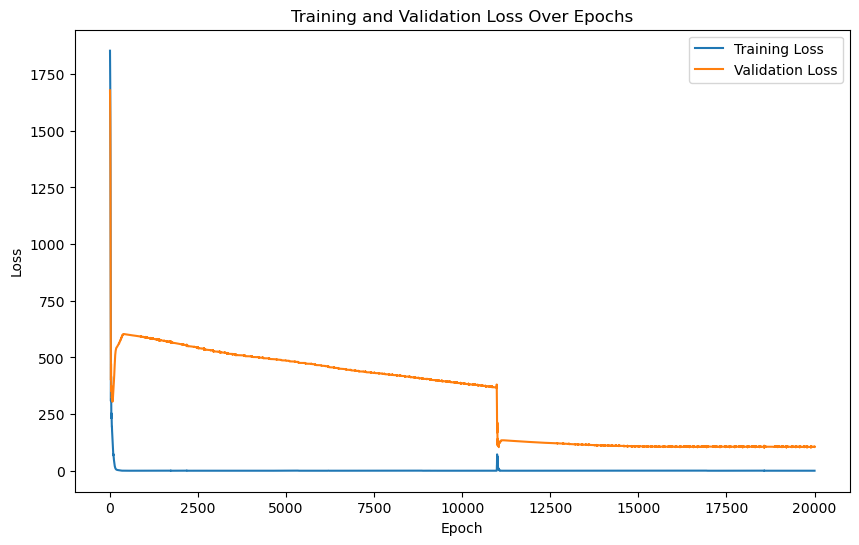

In [18]:
# regression_model.load_state_dict(torch.load('model_checkpoints/best_wgs_skin_age_regression_model.pth'))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

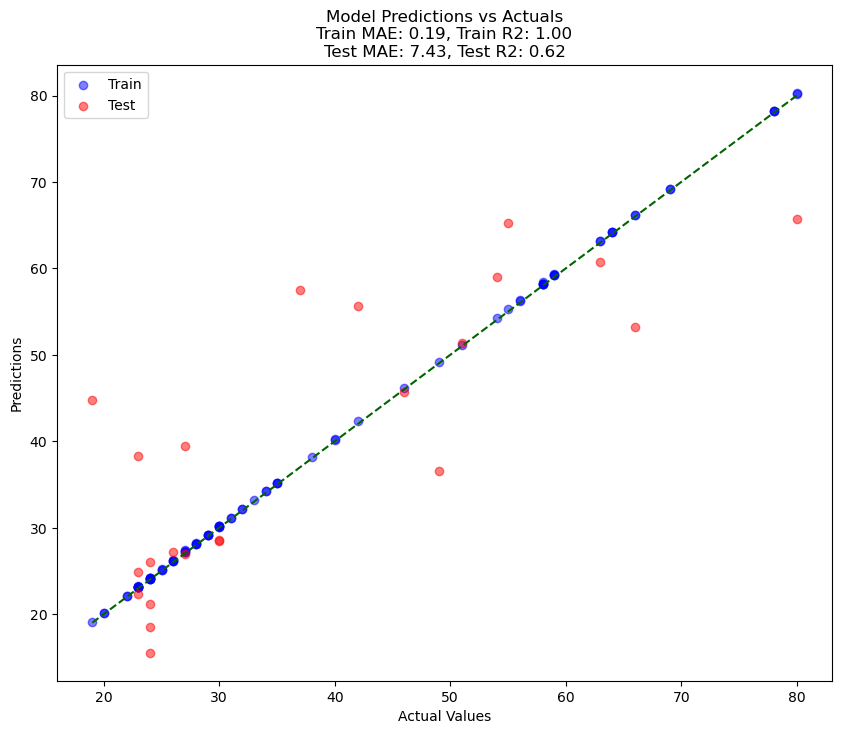

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# After training, evaluate the model on both the training and testing sets
regression_model.eval()  # Set the model to evaluation mode

# Collect predictions and actual values for the training set
train_preds, train_actuals = [], []
for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    batch_preds = regression_model(batch_features)['regression_output'].detach()
    train_preds.extend(batch_preds.view(-1).tolist())
    train_actuals.extend(batch_labels.view(-1).tolist())

# Collect predictions and actual values for the test set
test_preds, test_actuals = [], []
for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    batch_preds = regression_model(batch_features)['regression_output'].detach()
    test_preds.extend(batch_preds.view(-1).tolist())
    test_actuals.extend(batch_labels.view(-1).tolist())

train_mae = mean_absolute_error(train_actuals, train_preds)
test_mae = mean_absolute_error(test_actuals, test_preds)
train_r2 = r2_score(train_actuals, train_preds)
test_r2 = r2_score(test_actuals, test_preds)


# Plotting
plt.figure(figsize=(10, 8))

# Train predictions vs actuals
plt.scatter(train_actuals, train_preds, color='blue', alpha=0.5, label='Train')
# Test predictions vs actuals
plt.scatter(test_actuals, test_preds, color='red', alpha=0.5, label='Test')

# Perfect predictions line
plt.plot([min(train_actuals+test_actuals), max(train_actuals+test_actuals)], 
         [min(train_actuals+test_actuals), max(train_actuals+test_actuals)], 
         color='darkgreen', linestyle='--')

plt.title(f'Model Predictions vs Actuals\nTrain MAE: {train_mae:.2f}, Train R2: {train_r2:.2f}\nTest MAE: {test_mae:.2f}, Test R2: {test_r2:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

### feature extraction

In [21]:
import torch
import numpy as np
import shap

def batched_model_wrapper(x, batch_size=4):
    """
    A memory-efficient wrapper that processes input data in batches.
    
    Args:
        x: Input array to process
        batch_size: Number of samples to process at once
        
    Returns:
        numpy array: Concatenated model outputs
    """
    # Convert input to numpy if it isn't already
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    
    # Calculate number of batches
    n_samples = x.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))
    
    # List to store outputs
    outputs = []
    
    # Process each batch
    for i in range(n_batches):
        # Get batch indices
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        # Extract batch
        batch = x[start_idx:end_idx]
        
        # Convert to tensor and move to device
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        
        # Process batch
        with torch.no_grad():
            batch_output = regression_model(batch_tensor)
            
        # Convert output to numpy and store
        batch_numpy = batch_output['regression_output'].detach().cpu().numpy()
        outputs.append(batch_numpy)
    
    # Concatenate all batch outputs
    return np.concatenate(outputs, axis=0)

# Set the device appropriately
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
regression_model = regression_model.to(device)

# Create an explainer with the batched model wrapper
explainer = shap.Explainer(batched_model_wrapper, X_train)

In [22]:
X_combined = np.concatenate([X_train, X_test], axis=0)

In [23]:
shap_values = explainer(X_combined, max_evals=2*n_dimensions+1)

PermutationExplainer explainer: 116it [07:39,  4.07s/it]                         


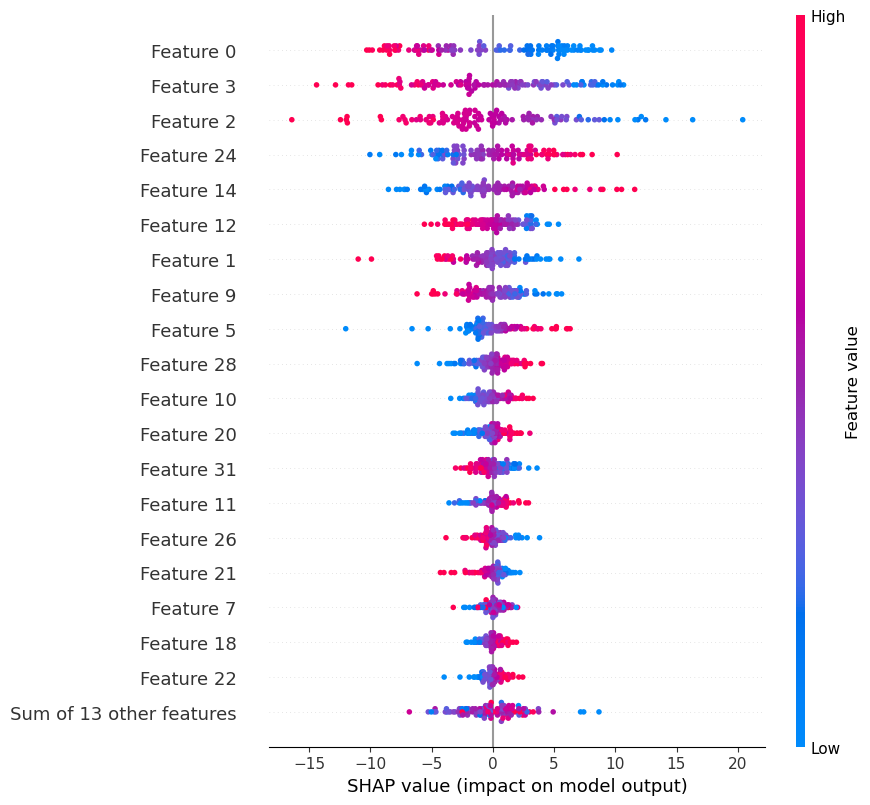

In [24]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.mean(0), max_display=20)

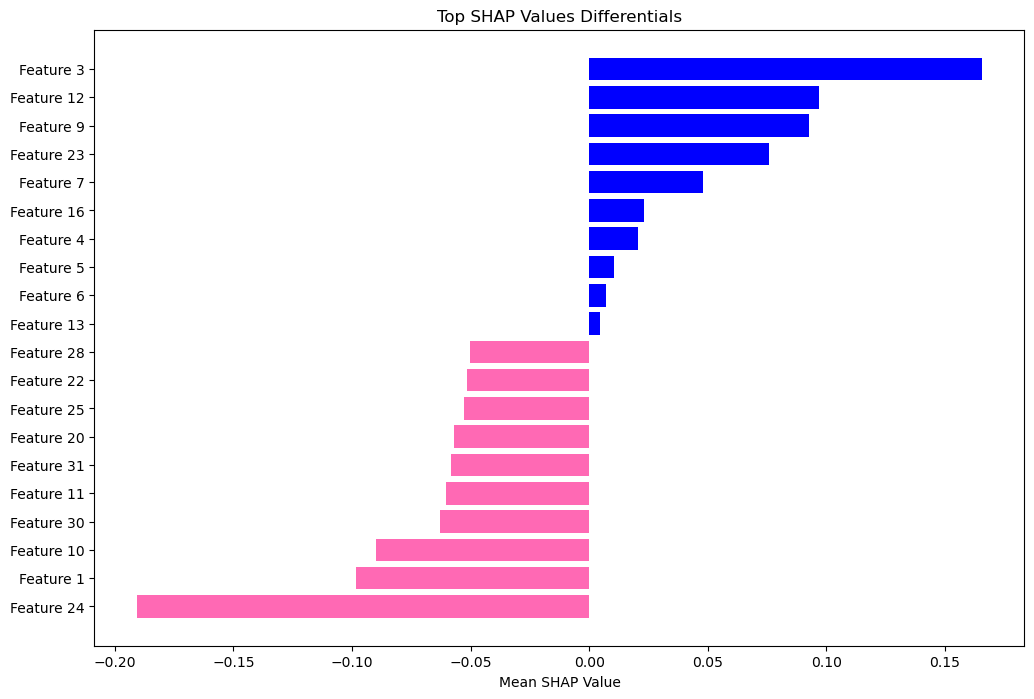

In [25]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Assuming shap_values is your SHAP values Explanation object
mean_shap_values = np.mean(shap_values.values, axis=0)

# Sort the SHAP values
sorted_indices = np.argsort(mean_shap_values)

# Get top 10 positive and top 10 negative features
top_10_positive_indices = sorted_indices[-10:]
top_10_negative_indices = sorted_indices[:10]

# Combine and sort them to plot
top_indices = np.concatenate([top_10_negative_indices, top_10_positive_indices])
top_indices_sorted = top_indices[np.argsort(mean_shap_values[top_indices])]

# Get the SHAP values for the top features
top_features = mean_shap_values[top_indices_sorted]
feature_names = np.array(shap_values.feature_names)[top_indices_sorted]

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.barh(feature_names, top_features, color=np.where(top_features > 0, 'blue', '#FF69B4'))
plt.xlabel('Mean SHAP Value')
plt.title('Top SHAP Values Differentials')
plt.show()


In [26]:
# Assuming:
# shap_values - SHAP values from your SHAP explainer, specific to the principal components
# pca_components - The components matrix from PCA, typically accessed via pca.components_

# Calculate the importance of each original feature
original_feature_importance = np.dot(shap_values.values, pca1.components_)

# Now, original_feature_importance contains the propagated SHAP values for each original feature.
# To get a summarized importance across all samples:
mean_abs_importance = np.mean(np.abs(original_feature_importance), axis=0)
mean_importance = np.mean(original_feature_importance, axis=0)
# To rank features by importance:
feature_ranking = np.argsort(-mean_abs_importance)  # Negate for descending order

feature_names = df1.columns  # Replace with actual feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Absolute Importance': mean_abs_importance,
    'Mean Importance': mean_importance,
})

importance_df = importance_df.iloc[feature_ranking]  # Sorted by importance

In [27]:
importance_df.head(10)

,Feature,Mean Absolute Importance,Mean Importance
388,k__Bacteria.p__Actinobacteria.c__Actinobacteri...,1.574899,-0.010377
267,k__Bacteria.p__Actinobacteria.c__Actinobacteri...,1.482395,0.058994
390,k__Eukaryota.p__Basidiomycota.c__Malasseziomyc...,1.470696,0.053423
376,k__Bacteria.p__Actinobacteria.c__Actinobacteri...,1.299085,0.046661
218,k__Bacteria.p__Proteobacteria.c__Alphaproteoba...,1.290288,0.013190
45,k__Bacteria.p__Actinobacteria.c__Actinobacteri...,1.216018,-0.003462
229,k__Bacteria.p__Proteobacteria.c__Gammaproteoba...,1.188889,-0.029884
219,k__Bacteria.p__Proteobacteria.c__Gammaproteoba...,1.177703,0.024037
406,k__Bacteria.p__Actinobacteria.c__Actinobacteri...,1.166110,0.012561
25,k__Bacteria.p__Proteobacteria.c__Gammaproteoba...,1.157475,0.019301


In [28]:
importance_df['Feature'] = importance_df['Feature'].str.replace('.', '; ')

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/3634469556.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  importance_df['Feature'] = importance_df['Feature'].str.replace('.', '; ')


In [ ]:
def get_valid_taxon(taxon_string):
    # Split the string by ';'
    parts = taxon_string.split(';')
    
    # Iterate backwards through the list
    for part in reversed(parts):
        # Check if the substring after '__' is non-empty
        if '__' in part and len(part.split('__')[1]) > 0:
            return part
    # If no valid part is found, return an empty string or handle it as needed
    return ""

def format_taxon(taxon_string):
    valid_taxon = get_valid_taxon(taxon_string)
    parts = taxon_string.split(';')
    
    if valid_taxon.startswith(' s__'):
        for part in reversed(parts):
            if part.startswith(' g__'):
                genus = part.split('__')[1]
                return f"{valid_taxon.split('__')[1]}"#f"{genus[0]}. {valid_taxon.split('__')[1]}"
    else:
        return valid_taxon.split('__')[1]


/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/2984142632.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cluster_df = pd.DataFrame(original_feature_importance, columns=feature_names.str.replace('.', '; '))
/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/2984142632.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top_cluster_features = feature_importance.index[:top_n].str.replace('.', '; ')


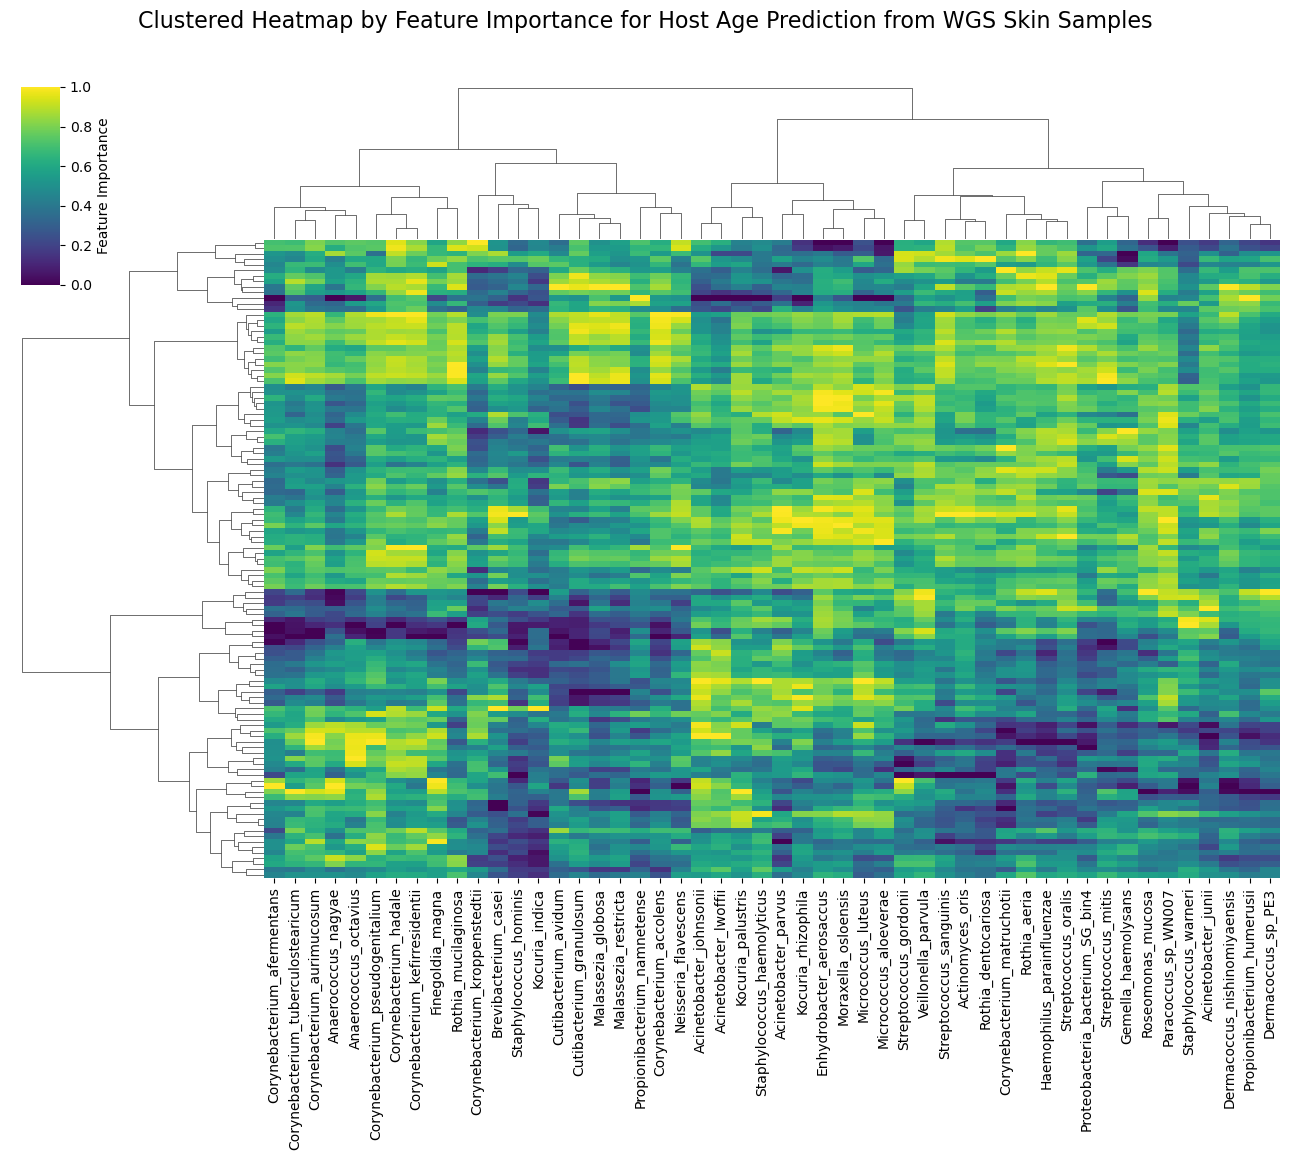

In [30]:
cluster_df = pd.DataFrame(original_feature_importance, columns=feature_names.str.replace('.', '; '))

# Calculate the mean absolute SHAP value for each feature
feature_importance = cluster_df.abs().mean().sort_values(ascending=False)

# Select the top N features
top_n = 50  # Adjust the number of features you want to keep
top_cluster_features = feature_importance.index[:top_n].str.replace('.', '; ')
# Filter the original data to keep only the top N features
filtered_data = cluster_df[top_cluster_features]
heatmap_cluster_feats = [format_taxon(top_cluster_features[i]) for i in range(len(top_cluster_features))]
# Normalize the filtered data
scaler = StandardScaler()
filtered_data_scaled = pd.DataFrame(scaler.fit_transform(filtered_data), columns=heatmap_cluster_feats)

# Create the clustered heatmap
sns.clustermap(
    filtered_data_scaled,
    cmap='viridis',
    figsize=(13, 11),  # Adjust the figure size as needed
    xticklabels=heatmap_cluster_feats,  # Add feature names as x-axis labels
    yticklabels=False,  # Disable y-axis labels if too many
    standard_scale=1,  # Normalize features
    metric='euclidean',
    method='ward',
    cbar_kws={'label': 'Feature Importance'},
    dendrogram_ratio=(.2, .2),  # Adjust dendrogram ratio
    col_cluster=True,  # Cluster columns as well
    cbar_pos=(0.02, 0.8, 0.03, 0.18)  # Adjust color bar position
)
# plt.title('Clustered Heatmap by Feature Importance for Host Age Prediction from 16S Skin Samples', loc='left')
plt.suptitle('Clustered Heatmap by Feature Importance for Host Age Prediction from WGS Skin Samples', x=0.5, y=1.05, ha='center', fontsize=16)

# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [31]:
cluster_cols = [format_taxon(feature_names.str.replace('.', '; ')[i]) for i in range(len(feature_names.str.replace('.', '; ')))]
cluster_df = pd.DataFrame(original_feature_importance, columns=cluster_cols, index=pd.concat([y_train, y_test]).index)

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/3390862021.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cluster_cols = [format_taxon(feature_names.str.replace('.', '; ')[i]) for i in range(len(feature_names.str.replace('.', '; ')))]
/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/3390862021.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cluster_cols = [format_taxon(feature_names.str.replace('.', '; ')[i]) for i in range(len(feature_names.str.replace('.', '; ')))]
/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_61210/3390862021.py:1: FutureWarning: The default value of regex will change from True to False in a future ver

In [32]:
# Get columns containing specified genera
genera_of_interest = ['Cutibacterium', 'Staphylococcus', 'Streptococcus', 'Malassezia']

# Create pattern to match any of these genera (case-insensitive)
filtered_cols = cluster_df.columns[
    cluster_df.columns.str.contains('|'.join(genera_of_interest), case=False)
]

# Create new dataframe with only those columns
filtered_cluster_df = cluster_df[filtered_cols].copy()

In [33]:
# Get columns where at least one value has absolute value > 1
high_abundance_cols = filtered_cluster_df.columns[
    (filtered_cluster_df.abs() > 1.25).any()
]

# Filter the dataframe to keep only those columns
filtered_cluster_df = filtered_cluster_df[high_abundance_cols]

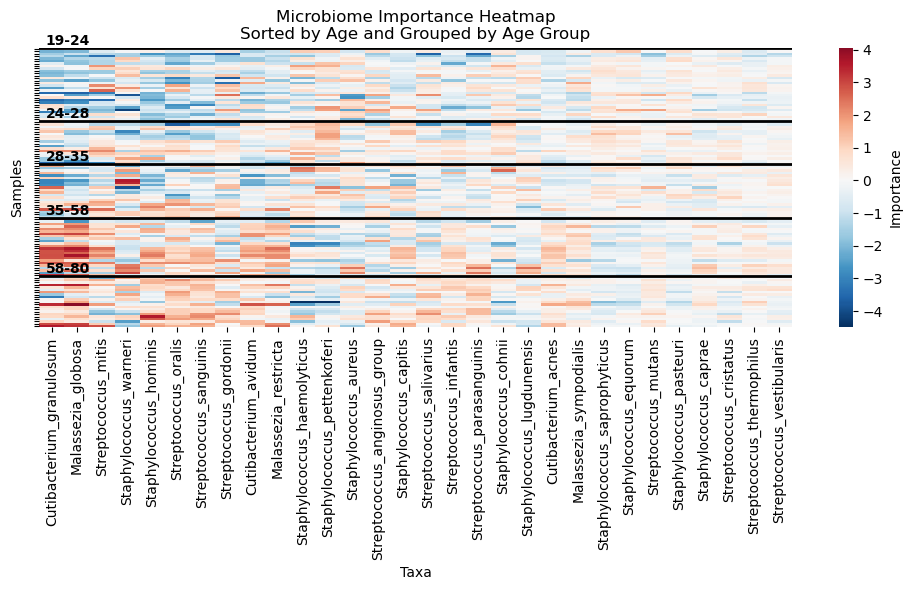

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_age_heatmap(abundance_data, age_metadata):
    # Merge abundance data with age metadata
    merged_data = abundance_data.merge(
        age_metadata[['age', 'age_group']], 
        left_index=True, 
        right_index=True
    )
    
    # Sort by age
    merged_data = merged_data.sort_values('age')
    
    # Get abundance columns (all except age and age_group)
    abundance_cols = [col for col in merged_data.columns if col not in ['age', 'age_group']]
    column_means = merged_data[abundance_cols].abs().mean()
    sorted_cols = column_means.sort_values(ascending=False).index
    
    # Create y-tick labels (every 5th label)
    y_labels = ['' if i % 10 == 1 else '' for i, label in enumerate(merged_data.index)]
    
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    
    # Create heatmap using seaborn
    sns.heatmap(
        merged_data[sorted_cols],
        cmap='RdBu_r',
        center=0,
        cbar_kws={'label': 'Importance'},
        yticklabels=y_labels,  # Use modified labels
    )
    
    # Add age group separators
    prev_group = None
    y_pos = 0
    for idx, group in enumerate(merged_data['age_group']):
        if group != prev_group:
            plt.axhline(y=y_pos, color='black', linewidth=2)
            plt.text(0.25, y_pos, f'{group}', rotation=0, verticalalignment='bottom', weight='bold')
        y_pos += 1
        prev_group = group
    
    plt.title('Microbiome Importance Heatmap\nSorted by Age and Grouped by Age Group')
    plt.xlabel('Taxa')
    plt.ylabel('Samples')
    plt.tight_layout()
    
    return plt

# Example usage:
plt = create_age_heatmap(filtered_cluster_df, age_metadata)
plt.show()

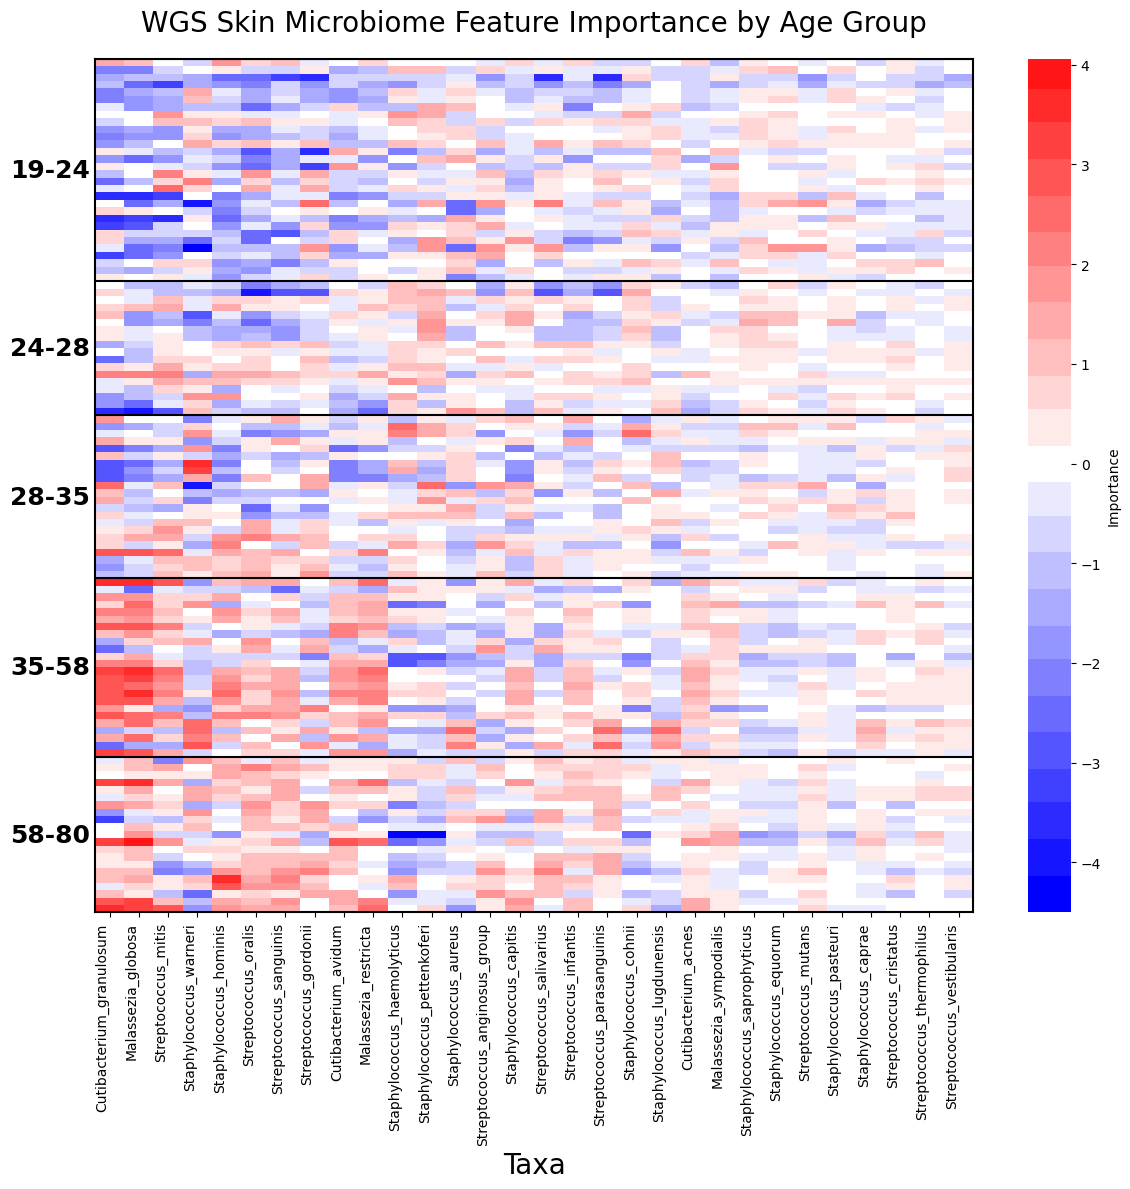

In [46]:
def create_age_heatmap(abundance_data, age_metadata):
    plt.figure(figsize=(12, 12))
    
    merged_data = abundance_data.merge(
        age_metadata[['age', 'age_group']], 
        left_index=True, 
        right_index=True
    ).sort_values('age')
    
    abundance_cols = [col for col in merged_data.columns if col not in ['age', 'age_group']]
    sorted_cols = merged_data[abundance_cols].abs().mean().sort_values(ascending=False).index
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['blue', 'white', 'red']
    n_bins = 25
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    ax = sns.heatmap(
        merged_data[sorted_cols],
        cmap=cmap,#'coolwarm',
        center=0,
        cbar_kws={'label': 'Importance'},
        yticklabels=False,
        xticklabels=True,

    )
    
    
    # Add group separators with padding
    prev_group = None
    y_pos = 0
    for idx, group in enumerate(merged_data['age_group']):
        if group != prev_group:
            plt.axhline(y=y_pos, color='black', linewidth=1.5)
            # plt.text(len(sorted_cols) + 2, y_pos + len(merged_data[merged_data['age_group']==group])/2, 
            #         group, fontsize=12, fontweight='bold', va='center')
            # Replace the plt.text line with:
            plt.text(-2.9, y_pos + len(merged_data[merged_data['age_group']==group])/2, 
                    group, fontsize=18, fontweight='bold', va='center')
        y_pos += 1
        prev_group = group
    
    plt.xticks(rotation=90, ha='right')
    plt.title('WGS Skin Microbiome Feature Importance by Age Group', pad=20, fontsize=20)
    plt.xlabel('Taxa', fontsize=20)
    
    # Add border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    return plt
plt = create_age_heatmap(filtered_cluster_df, age_metadata)
plt.show()

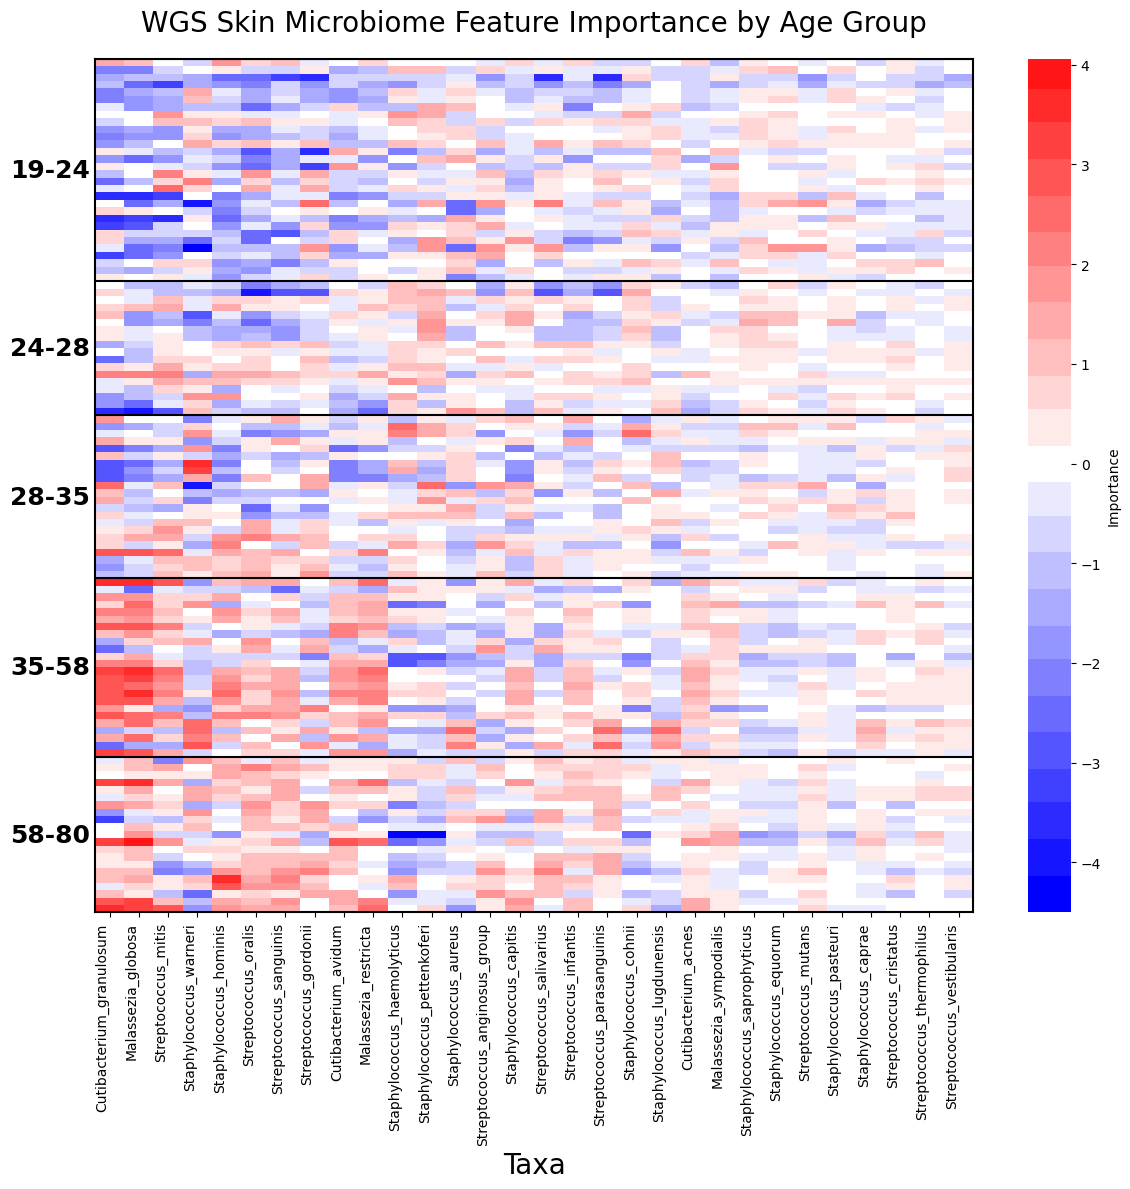

In [47]:
def create_age_heatmap(abundance_data, age_metadata, output_path='heatmap_figure.pdf'):
    plt.figure(figsize=(12, 12))
    
    merged_data = abundance_data.merge(
        age_metadata[['age', 'age_group']], 
        left_index=True, 
        right_index=True
    ).sort_values('age')
    
    abundance_cols = [col for col in merged_data.columns if col not in ['age', 'age_group']]
    sorted_cols = merged_data[abundance_cols].abs().mean().sort_values(ascending=False).index
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['blue', 'white', 'red']
    n_bins = 25
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    ax = sns.heatmap(
        merged_data[sorted_cols],
        cmap=cmap,
        center=0,
        cbar_kws={'label': 'Importance'},
        yticklabels=False,
        xticklabels=True,
    )
    
    # Add group separators with padding
    prev_group = None
    y_pos = 0
    for idx, group in enumerate(merged_data['age_group']):
        if group != prev_group:
            plt.axhline(y=y_pos, color='black', linewidth=1.5)
            plt.text(-2.9, y_pos + len(merged_data[merged_data['age_group']==group])/2, 
                    group, fontsize=18, fontweight='bold', va='center')
        y_pos += 1
        prev_group = group
    
    plt.xticks(rotation=90, ha='right')
    plt.title('WGS Skin Microbiome Feature Importance by Age Group', pad=20, fontsize=20)
    plt.xlabel('Taxa', fontsize=20)
    
    # Add border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Save the figure as a PDF with high quality
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    
    return plt

# Example usage:
plt = create_age_heatmap(filtered_cluster_df, age_metadata, output_path='wgs_skin_microbiome_heatmap.pdf')
plt.show()

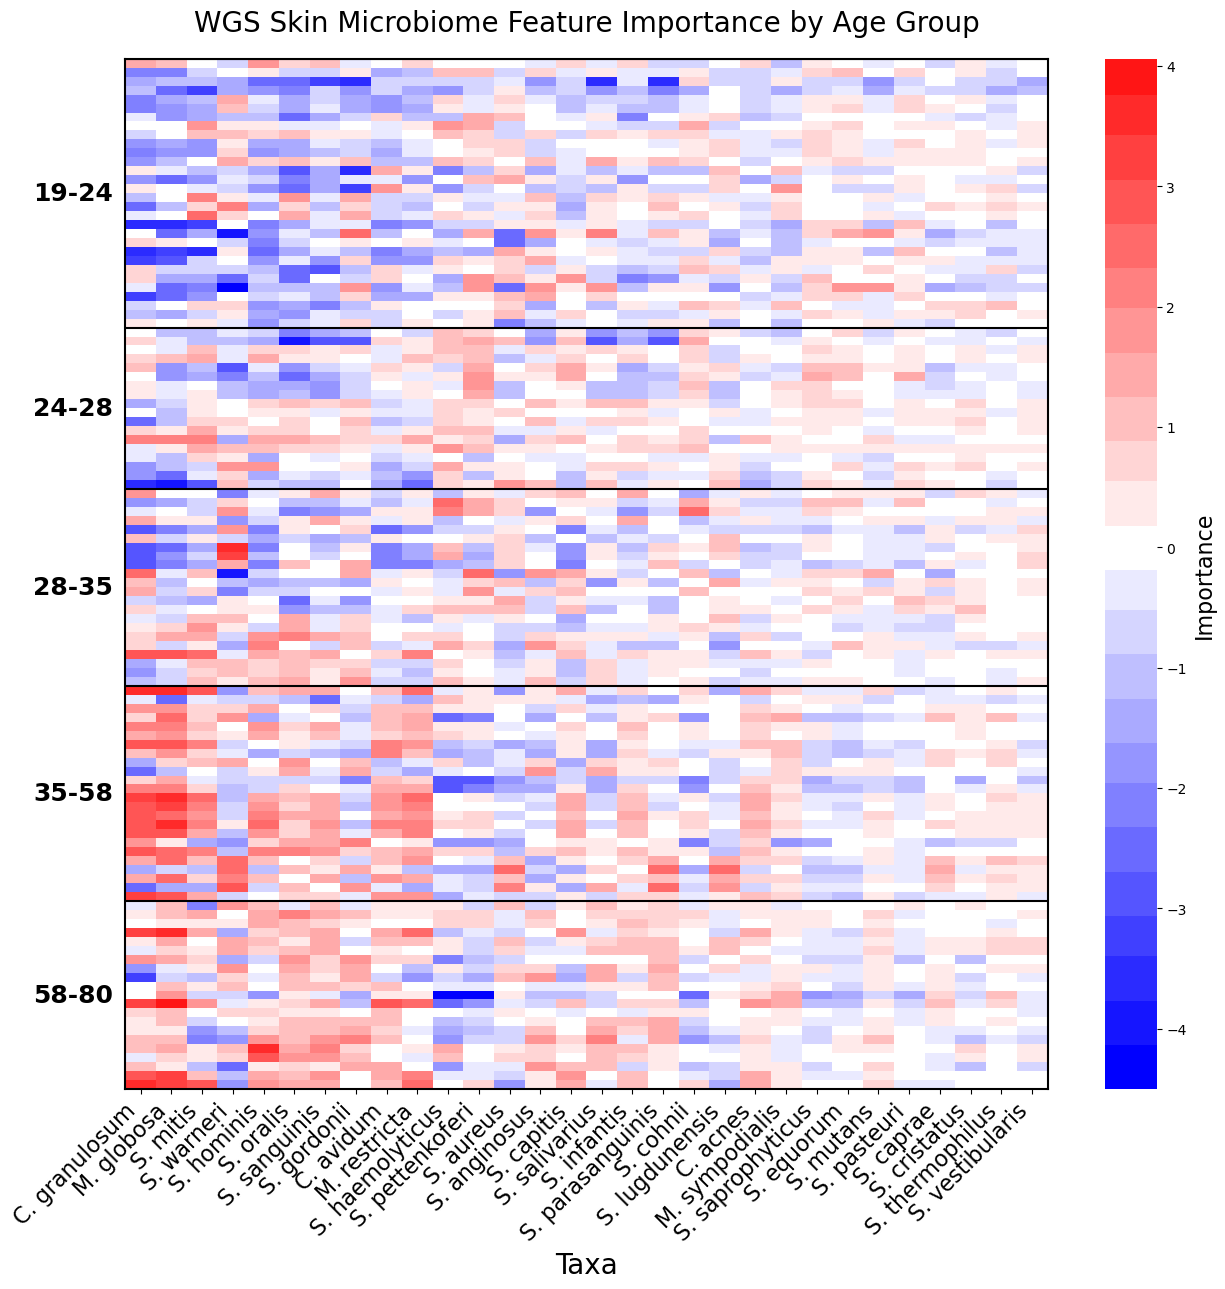

In [53]:
def create_age_heatmap(abundance_data, age_metadata, output_path='heatmap_figure.pdf'):
    plt.figure(figsize=(13, 13))
    
    merged_data = abundance_data.merge(
        age_metadata[['age', 'age_group']], 
        left_index=True, 
        right_index=True
    ).sort_values('age')
    
    abundance_cols = [col for col in merged_data.columns if col not in ['age', 'age_group']]
    sorted_cols = merged_data[abundance_cols].abs().mean().sort_values(ascending=False).index
    
    # Format taxa names
    def format_taxa_name(name):
        if '_' in name:
            parts = name.split('_')
            return f"{parts[0][0]}. {parts[1]}"
        return name
    
    formatted_taxa = {col: format_taxa_name(col) for col in sorted_cols}
    
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['blue', 'white', 'red']
    n_bins = 25
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    ax = sns.heatmap(
        merged_data[sorted_cols],
        cmap=cmap,
        center=0,
        cbar_kws={'label': 'Importance'},  # Remove labelsize parameter
        yticklabels=False,
        xticklabels=[formatted_taxa[col] for col in sorted_cols],  # Use formatted names
    )
    
    # Increase the font size for colorbar label after creating the heatmap
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('Importance', fontsize=16)
    
    # Add group separators with padding
    prev_group = None
    y_pos = 0
    for idx, group in enumerate(merged_data['age_group']):
        if group != prev_group:
            plt.axhline(y=y_pos, color='black', linewidth=1.5)
            plt.text(-3, y_pos + len(merged_data[merged_data['age_group']==group])/2, 
                     group, fontsize=18, fontweight='bold', va='center')
        y_pos += 1
        prev_group = group
    
    # Adjust x-axis labels with angle and larger font
    plt.xticks(rotation=45, ha='right', fontsize=16)  # Changed angle to 45 and increased font size
    plt.title('WGS Skin Microbiome Feature Importance by Age Group', pad=20, fontsize=20)
    plt.xlabel('Taxa', fontsize=20)
    
    # Add border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Save the figure as a PDF with high quality
    plt.savefig(output_path, format='pdf', dpi=300, bbox_inches='tight')
    
    return plt

# Example usage:
plt = create_age_heatmap(filtered_cluster_df, age_metadata, output_path='wgs_skin_microbiome_heatmap.pdf')
plt.show()

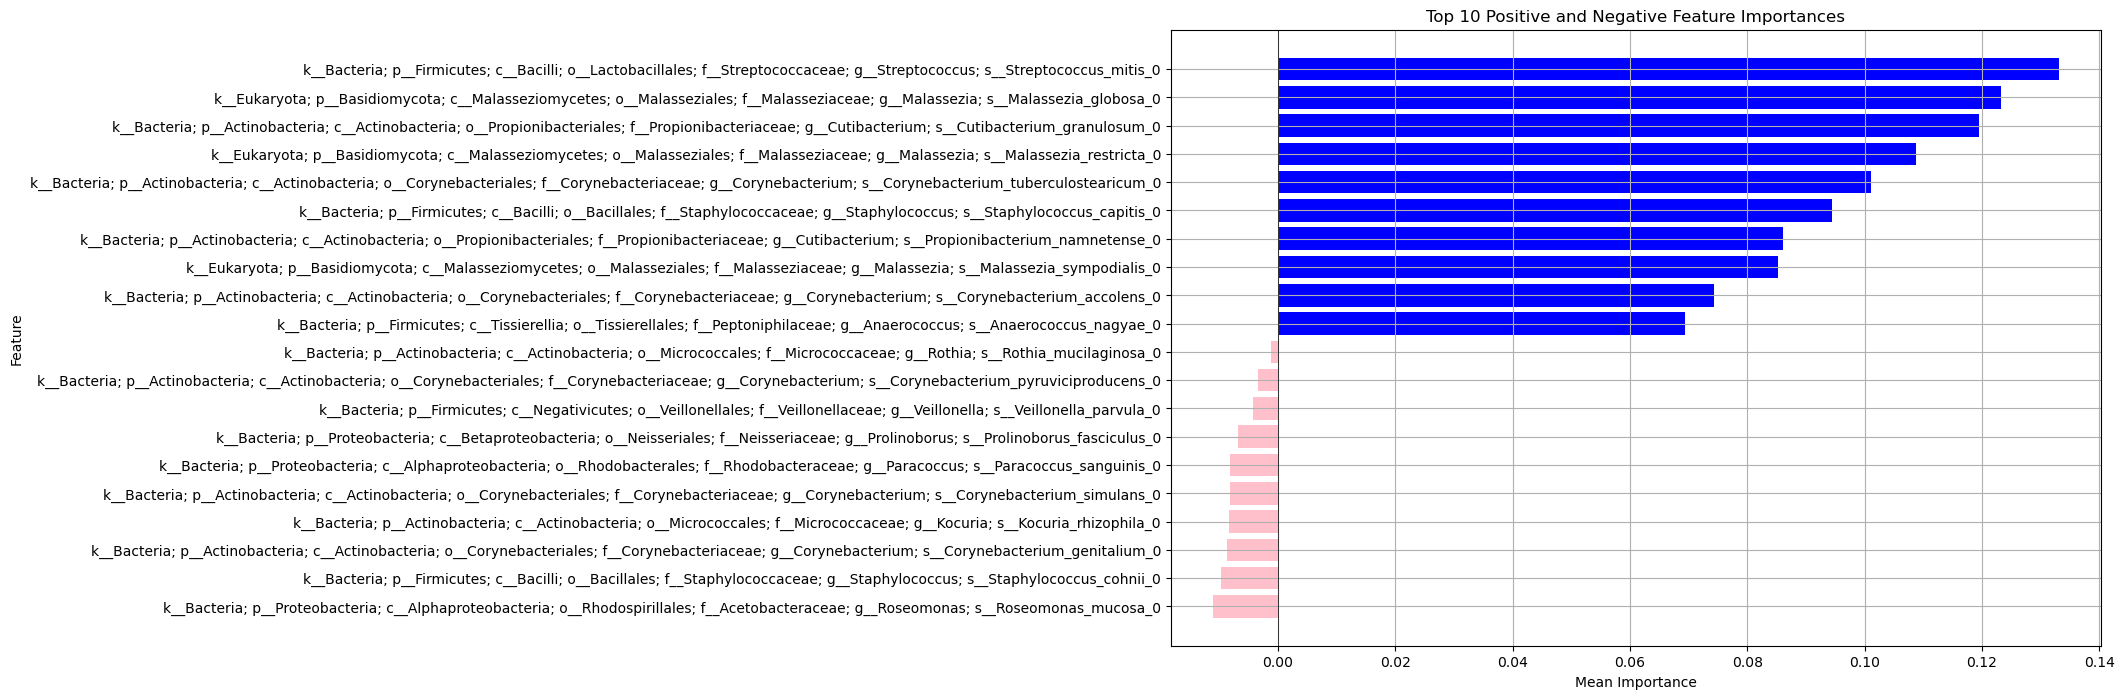

In [40]:
# Sort the DataFrame by 'Mean Absolute Importance' in descending order
importance_df_sorted = importance_df.sort_values(by='Mean Absolute Importance', ascending=False)

# Extract the top features after sorting by 'Mean Absolute Importance'
top_features = importance_df_sorted.head(100)  # Considering a larger number to then filter by Mean Importance

# Separate the top positive and top negative Mean Importance values
top_positive = top_features[top_features['Mean Importance'] > 0].sort_values(by='Mean Importance', ascending=False).head(10)
top_negative = top_features[top_features['Mean Importance'] < 0].sort_values(by='Mean Importance', ascending=False).head(10)

# Combine top positive and negative features
combined_df = pd.concat([top_positive, top_negative])
combined_df['Feature'] = combined_df['Feature']#.map(taxon_dict)

# Add unique suffixes to feature names to differentiate them
feature_count = {}
unique_features = []
for feature in combined_df['Feature']:
    if feature in feature_count:
        feature_count[feature] += 1
        unique_feature = f"{feature}_{feature_count[feature]}"
    else:
        feature_count[feature] = 0
        unique_feature = f"{feature}_{feature_count[feature]}"
    unique_features.append(unique_feature)

combined_df['Unique Feature'] = unique_features

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(combined_df['Unique Feature'], combined_df['Mean Importance'], color=['blue' if x >= 0 else 'pink' for x in combined_df['Mean Importance']])
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Top 10 Positive and Negative Feature Importances')
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()  # To have the top positive values on the top
plt.grid(True)
plt.show()